In [1]:
import pandas as pd
import numpy as np

import warnings
import matplotlib.colors as mcolors

import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('online_retail_II.csv')

In [3]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [5]:
data.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [6]:
data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [7]:
data.rename(columns={'Customer ID':'CustomerID'}, inplace=True)

In [8]:
data.shape

(1067371, 8)

In [9]:
data.dropna(subset=['CustomerID'],inplace=True)

In [10]:
# Unique Order Count
n_orders = data.groupby(['CustomerID'])['Invoice'].nunique()

# Part of the number of orders placed more than once by the Number of Customers
mult_orders_perc = np.sum(n_orders>1)/ data['CustomerID'].nunique()
print(f"{100 * mult_orders_perc:.2f}% of customers ordered more than once")

75.41% of customers ordered more than once


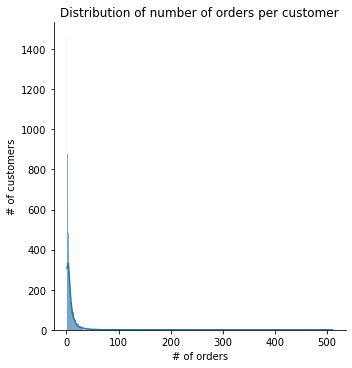

In [11]:
ax = sns.displot(data=data, x=n_orders, kde=True, kind='hist')
ax.set(title="Distribution of number of orders per customer",
      xlabel = '# of orders',
      ylabel = '# of customers');

# Cohort Analysis

In [14]:
#convert into datetime objects 
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [15]:
# Make and apply function to truncate given date in column to a first day of the month

def get_month(x): return dt.datetime(x.year, x.month, 1)
data['InvoiceMonth'] = data['InvoiceDate'].apply(get_month)

# --group same-month-purchase customers into cohorts -
data.rename(columns={ data.columns[6]: "CustomerID" }, inplace = True)
grouped = data.groupby('CustomerID')['InvoiceMonth']
data['CohortMonth'] = grouped.transform('min')

data.describe()

,Quantity,Price,CustomerID
count,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,15324.638504
std,188.976099,70.241388,1697.464450
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,5.000000,1.950000,15255.000000
75%,12.000000,3.750000,16797.000000
max,80995.000000,38970.000000,18287.000000


In [16]:
#now we create a way to index cohorts based on how many months have passed since the time of acquisition & first purchase 

def get_date_int(data, column):
    year = data[column].dt.year
    month = data[column].dt.month
    day = data[column].dt.day
    return year, month, day
invoice_year, invoice_month, _ = get_date_int(data, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(data, 'CohortMonth')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

data['CohortIndex'] = years_diff * 12 + months_diff + 1
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01,2009-12-01,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,2009-12-01,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,2009-12-01,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12-01,2009-12-01,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12-01,2009-12-01,1


In [22]:
grouping_count = data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_count['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='CustomerID')
cohort_counts.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12-01,1045.0,392.0,358.0,447.0,410.0,408.0,408.0,374.0,355.0,392.0,...,319.0,273.0,316.0,303.0,287.0,274.0,332.0,319.0,427.0,218.0
2010-01-01,394.0,86.0,119.0,120.0,110.0,115.0,105.0,91.0,114.0,134.0,...,60.0,86.0,74.0,69.0,73.0,93.0,73.0,88.0,29.0,NaN
2010-02-01,363.0,109.0,82.0,110.0,93.0,76.0,79.0,103.0,100.0,106.0,...,74.0,67.0,61.0,53.0,85.0,90.0,62.0,23.0,NaN,NaN
2010-03-01,436.0,95.0,113.0,103.0,100.0,87.0,105.0,130.0,126.0,50.0,...,74.0,76.0,69.0,74.0,89.0,93.0,33.0,NaN,NaN,NaN
2010-04-01,291.0,67.0,58.0,47.0,54.0,67.0,79.0,76.0,33.0,34.0,...,43.0,41.0,41.0,50.0,61.0,19.0,NaN,NaN,NaN,NaN


In [18]:
#Retention analysis 
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention.index = retention.index.strftime('%m-%Y')

In [20]:
#Average quantity analysis 
grouping_qty = data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data_qty = grouping_qty['Quantity'].mean()
cohort_data_qty = cohort_data_qty.reset_index()
average_quantity = cohort_data_qty.pivot(index='CohortMonth',
                                     columns='CohortIndex',
                                     values='Quantity')
average_quantity.index = average_quantity.index.strftime('%m-%Y')

#Average price analysis 
grouping_price = data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data_price = grouping_price['Price'].mean()
cohort_data_price = cohort_data_price.reset_index()
average_price = cohort_data_price.pivot(index='CohortMonth',
                                     columns='CohortIndex',
                                     values='Price')
average_price.index = average_price.index.strftime('%m-%Y')

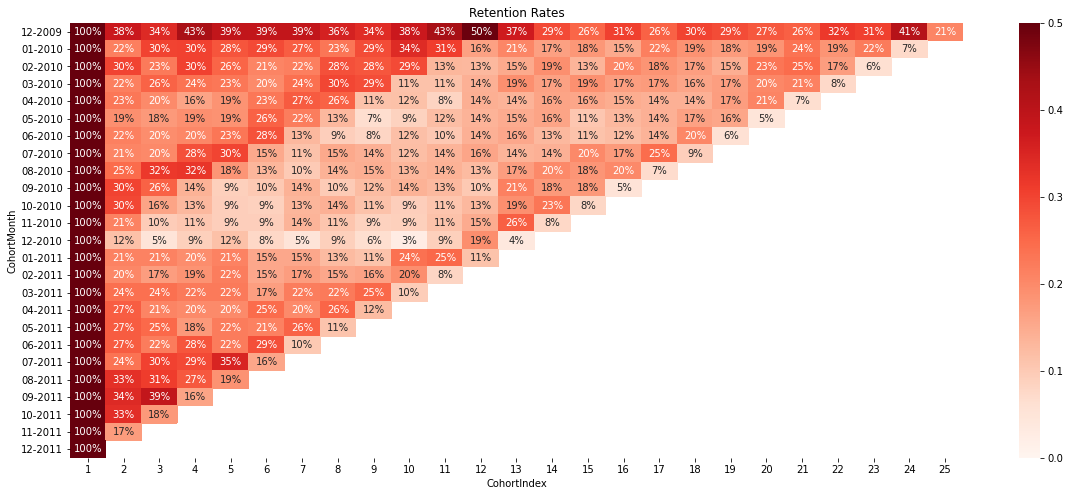

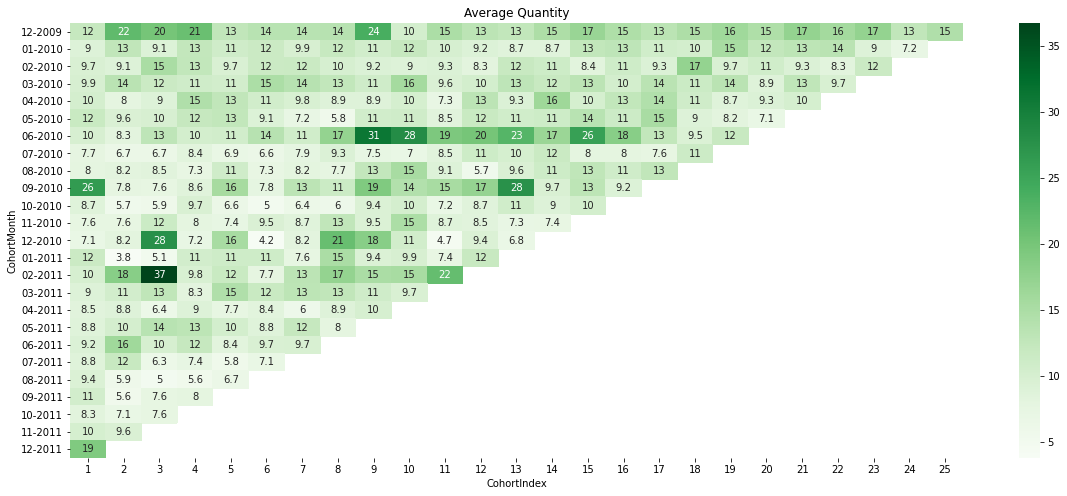

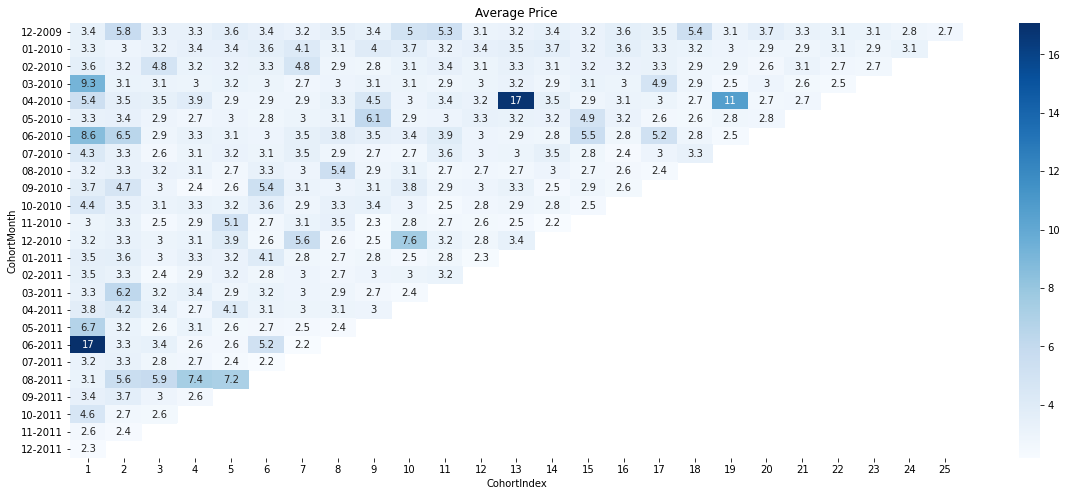

In [21]:
# --Plot heatmaps using seaborn--

# Plot retention rates
plt.figure(figsize=(20, 8))
plt.title('Retention Rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'Reds')
plt.show()

# Plot average quantity
plt.figure(figsize=(20, 8))
plt.title('Average Quantity')
sns.heatmap(data = average_quantity, annot=True, cmap='Greens')
plt.show()

# Plot average price
plt.figure(figsize=(20, 8))
plt.title('Average Price')
sns.heatmap(data = average_price, annot=True, cmap='Blues')
plt.show()
